# The Deutsch-Jozsa algorithm

## 1. Quantum parallelism and its limits

| $x$ | $f_1(x)$ | $f_2(x)$ | $f_3(x)$ | $f_4(x)$ |
| --- | -------- | -------- | -------- | -------- |
| 0   | 0        | 0        | 1        | 1        |
| 1   | 0        | 1        | 0        | 1        |

We'd like to find out which of these functions (1-4) our $f(x)$ is. Classically, we would need to run the function twice — once for $x=0$, once for $x=1$. But let's see if we can do better with a quantum circuit.

In [1]:
# Load the Qiskit Runtime service
from qiskit_ibm_runtime import QiskitRuntimeService

# Load the Runtime primitive and session
from qiskit_ibm_runtime import SamplerV2 as Sampler


service = QiskitRuntimeService(channel="ibm_quantum_platform", token="_v9gTYOWfOOwvrDL9E00jnZxsKVyP0k9LwO6bKI9Q1ik")

# Use the least busy backend, or uncomment the loading of a specific backend like "ibm_brisbane".
# backend = service.least_busy(operational=True, simulator=False, min_num_qubits = 127)
backend = service.backend("ibm_brisbane")
print(backend.name)


sampler = Sampler(mode=backend)

C:\Users\Tesfu\AppData\Local\Temp\ipykernel_10436\1925029199.py:2: DeprecationWarning: Using qiskit-ibm-runtime with Python 3.9 is deprecated as of the 0.41.0 release. Support for running qiskit-ibm-runtime with Python 3.9 will be removed in a future release.
  from qiskit_ibm_runtime import QiskitRuntimeService
qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-08-21 15:30:23,030: Default instance not set. Searching all available instances.


ibm_brisbane


The cell below will allow you to switch between using the simulator or real hardware throughout the notebook.



In [2]:
# Load the backend sampler
from qiskit.primitives import BackendSamplerV2

# Load the Aer simulator and generate a noise model based on the currently-selected backend.
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel

# Alternatively, load a fake backend with generic properties and define a simulator.
from qiskit.providers.fake_provider import GenericBackendV2


noise_model = NoiseModel.from_backend(backend)

# Define a simulator using Aer, and use it in Sampler.
backend_sim = AerSimulator(noise_model=noise_model)
sampler_sim = BackendSamplerV2(backend=backend_sim)


backend_gen = GenericBackendV2(num_qubits=18)
sampler_gen = BackendSamplerV2(backend=backend_gen)

we first make function that selects among the four possible functions taking a single bit to another single bit.

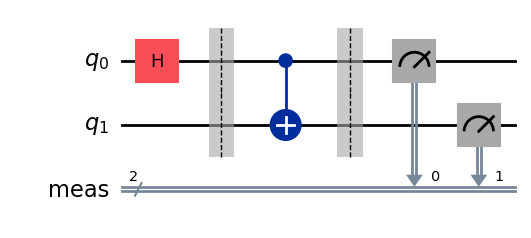

In [3]:
# Step 1: Map

from qiskit import QuantumCircuit

qc = QuantumCircuit(2)


def twobit_function(case: int):
    """
    Generate a valid two-bit function as a `QuantumCircuit`.
    """
    if case not in [1, 2, 3, 4]:
        raise ValueError("`case` must be 1, 2, 3, or 4.")

    f = QuantumCircuit(2)
    if case in [2, 3]:
        f.cx(0, 1)
    if case in [3, 4]:
        f.x(1)
    return f


# first, convert oracle circuit (above) to a single gate for drawing purposes. otherwise, the circuit is too large to display
# blackbox = twobit_function(2).to_gate() 
# blackbox.label = "$U_f$"

qc.h(0)
qc.barrier()
qc.compose(twobit_function(2), inplace=True)
qc.measure_all()


qc.draw("mpl")

Next we need to optimize and transpile the circuit to be run on the quantum computer:

In [4]:
# Step 2: Transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

qc_isa = pm.run(qc)

Finally, we execute our transpiled circuit on the quantum computer and visualize our results:



In [5]:
# Step 3: Run the job on a real quantum computer

job = sampler.run([qc_isa], shots=1)
# job = sampler_sim.run([qc_isa],shots=1) # uncomment this line to run on simulator instead
res = job.result()
counts = res[0].data.meas.get_counts()

# job = sampler_gen.run([qc_isa],shots=1)
# res=job.result()
# counts=res[0].data.c.get_counts()

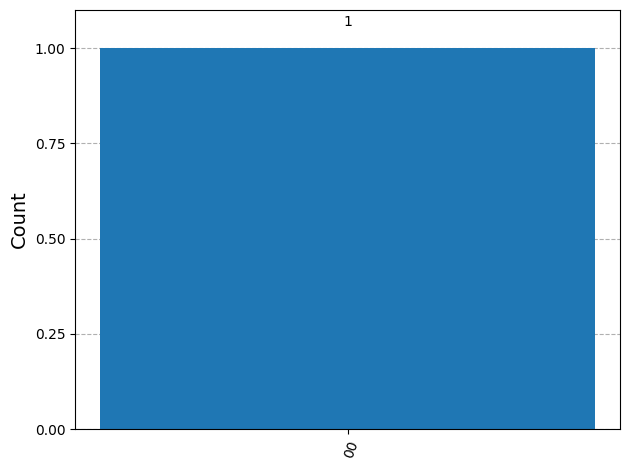

In [6]:
# Step 4: Visualize and analyze results

## Analysis
from qiskit.visualization import plot_histogram

plot_histogram(counts)

## 2. Deutsch's Algorithm

While quantum parallelism alone doesn't give us an advantage over classical computers, we can pair this with another quantum phenomena, interference, to achieve a speed-up. The algorithm now known as "Deutsch's algorithm" is the first example of an algorithm that accomplishes this.

### 2.1. The Problem

Here was the problem:

Given an input bit, $x = \{0,1\}$, and an input function $f(x) = \{0,1\}$, determine whether the function is *balanced* or *constant*. That is, if it's balanced, then the output of the function is 0 half the time and 1 the other half the time. If it's constant, then the output of the function is either always 0 or always 1. Recall the table of four possible functions taking a single bit to another a single bit:

| $x$ | $f_1(x)$ | $f_2(x)$ | $f_3(x)$ | $f_4(x)$ |
| --- | -------- | -------- | -------- | -------- |
| 0   | 0        | 0        | 1        | 1        |
| 1   | 0        | 1        | 0        | 1        |

The first and the last functions, $f_1(x)$ and $f_4(x)$, are constant, while the middle two functions, $f_2(x)$ and $f_3(x)$, are balanced.



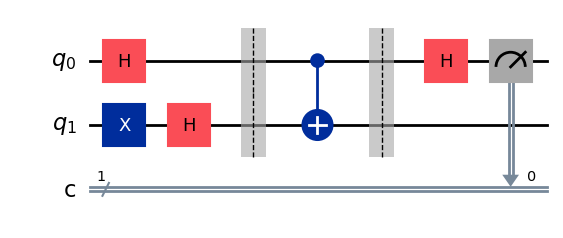

In [7]:
## Deutsch's algorithm:

qc_deutsch = QuantumCircuit(2, 1)

qc_deutsch.x(1)
qc_deutsch.h(range(2))

qc_deutsch.barrier()
qc_deutsch.compose(twobit_function(2), inplace=True)
qc_deutsch.barrier()

qc_deutsch.h(0)
qc_deutsch.measure(0, 0)

qc_deutsch.draw("mpl")

In [9]:
# Step 2: Transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

qc_isa = pm.run(qc_deutsch)

In [10]:
# Step 3: Run the job on a real quantum computer

job = sampler.run([qc_isa], shots=1)
# job = sampler_sim.run([qc_isa],shots=1) # uncomment this line to run on simulator instead
res = job.result()
counts = res[0].data.c.get_counts()

# job = sampler_gen.run([qc_isa],shots=1)
# res=job.result()
# counts=res[0].data.c.get_counts()

In [11]:
# Step 4: Visualize and analyze results

## Analysis
print(counts)
if "1" in counts:
    print("balanced")
else:
    print("constant")

{'1': 1}
balanced


## 3. The Deutsch-Jozsa algorithm

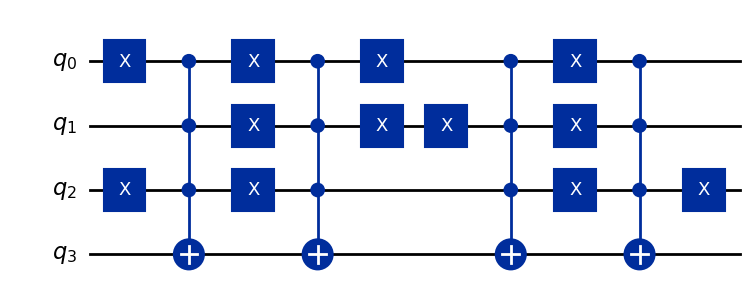

In [12]:
from qiskit import QuantumCircuit
import numpy as np


def dj_function(num_qubits):
    """
    Create a random Deutsch-Jozsa function.
    """

    qc_dj = QuantumCircuit(num_qubits + 1)
    if np.random.randint(0, 2):
        # Flip output qubits with 50% chance
        qc_dj.x(num_qubits)
    if np.random.randint(0, 2):
        # return constant circuit with 50% chance.
        return qc_dj

    # If the "if" statement above was "TRUE" then we've returned the constant
    # function and the function is complete. If not, we proceed in creating our
    # balanced function. Everything below is to produce the balanced function:

    # select half of all possible states at random:
    on_states = np.random.choice(
        range(2**num_qubits),  # numbers to sample from
        2**num_qubits // 2,  # number of samples
        replace=False,  # makes sure states are only sampled once
    )

    def add_cx(qc_dj, bit_string):
        for qubit, bit in enumerate(reversed(bit_string)):
            if bit == "1":
                qc_dj.x(qubit)
        return qc_dj

    for state in on_states:
        # qc_dj.barrier()  # Barriers are added to help visualize how the functions are created. They can safely be removed.
        qc_dj = add_cx(qc_dj, f"{state:0b}")
        qc_dj.mcx(list(range(num_qubits)), num_qubits)
        qc_dj = add_cx(qc_dj, f"{state:0b}")

    # qc_dj.barrier()

    return qc_dj


n = 3  # number of input qubits

oracle = dj_function(n)

display(oracle.draw("mpl"))

To query the box, we use the Deutsch-Jozsa algorithm and determine whether the function is constant or balanced:

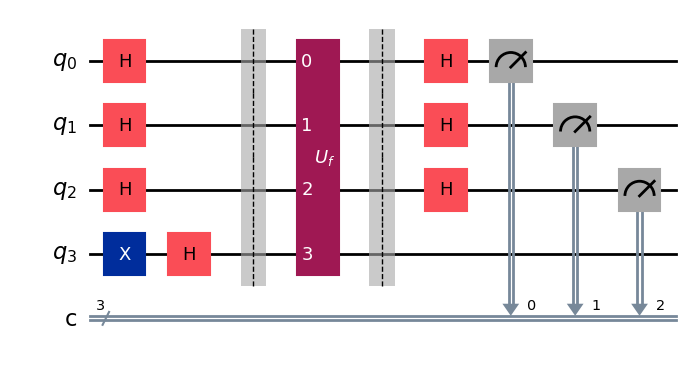

In [13]:
blackbox = oracle.to_gate()
blackbox.label = "$U_f$"


qc_dj = QuantumCircuit(n + 1, n)
qc_dj.x(n)
qc_dj.h(range(n + 1))
qc_dj.barrier()
qc_dj.compose(blackbox, inplace=True)
qc_dj.barrier()
qc_dj.h(range(n))
qc_dj.measure(range(n), range(n))

qc_dj.decompose().decompose()


qc_dj.draw("mpl")

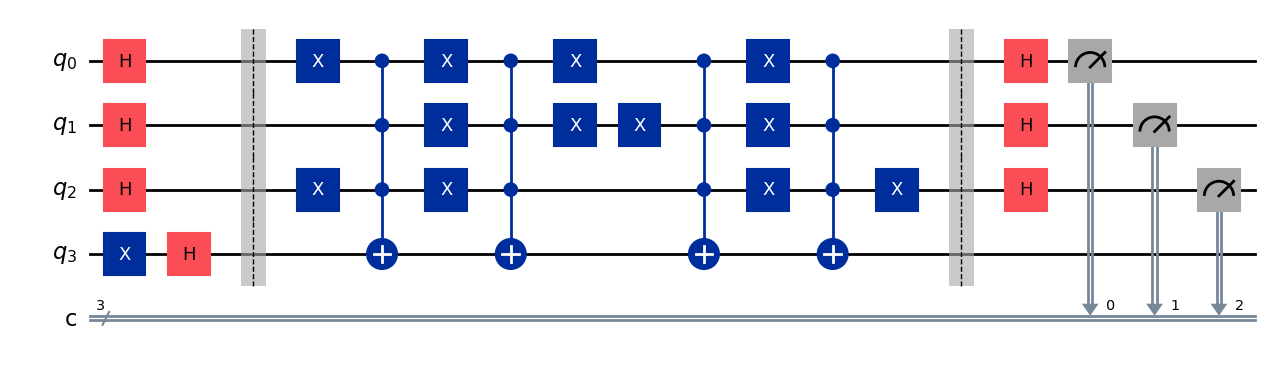

In [14]:
# Step 1: Map the problem

qc_dj = QuantumCircuit(n + 1, n)
qc_dj.x(n)
qc_dj.h(range(n + 1))
qc_dj.barrier()
qc_dj.compose(oracle, inplace=True)
qc_dj.barrier()
qc_dj.h(range(n))
qc_dj.measure(range(n), range(n))

qc_dj.decompose().decompose()


qc_dj.draw("mpl")

In [15]:
# Step 2: Transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

qc_isa = pm.run(qc_dj)

In [16]:
# Step 3: Run the job on a real quantum computer

job = sampler.run([qc_isa], shots=1)
# job = sampler_sim.run([qc_isa],shots=1) # uncomment this line to run on simulator instead
res = job.result()
counts = res[0].data.c.get_counts()

# job = sampler_gen.run([qc_isa],shots=1)
# res=job.result()
# counts=res[0].data.c.get_counts()

In [17]:
# Step 4: Visualize and analyze results

## Analysis
print(counts)

if (
    "0" * n in counts
):  # The D-J algorithm returns all zeroes if the function was constant
    print("constant")
else:
    print("balanced")  # anything other than all zeroes means the function is balanced.

{'110': 1}
balanced
